In [1]:
import zipfile
import os

# Zip file path
zip_file_path = '/content/drive/MyDrive/train data/traindata.zip'

# extracting file directory
extract_to = 'heartrate'

# Create the directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")

Files extracted to heartrate


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load the datasets
frequency_data = pd.read_csv('/content/heartrate/traindata/Train Data Zip/frequency_domain_features_train.csv')
non_linear_data = pd.read_csv('/content/heartrate/traindata/Train Data Zip/heart_rate_non_linear_features_train.csv')
time_domain_data = pd.read_csv('/content/heartrate/traindata/Train Data Zip/time_domain_features_train.csv')

# Merge the datasets on 'uuid'
merged_data = pd.merge(frequency_data, non_linear_data, on='uuid')
merged_data = pd.merge(merged_data, time_domain_data, on='uuid')

# Drop 'uuid' column
merged_data = merged_data.drop(columns=['uuid'])

# Drop any remaining non-numeric columns (like 'condition' if it exists)
merged_data = merged_data.select_dtypes(exclude=['object'])

In [4]:
# Split features (X) and target (y)
X = merged_data.drop(columns=['HR'])  # Features (everything except heart rate)
y = merged_data['HR']  # Target (heart rate)

# **Section 4: Train-Test Split and Feature Scaling**
# Split data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features and target variable using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform X_train, X_test, y_train, and y_test
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape data for Conv1D input (samples, time steps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [5]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# **Section 6: Early Stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
# **Section 7: Train the Model**
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
500/500 - 9s - 19ms/step - loss: 0.0123 - mae: 0.0799 - val_loss: 0.0129 - val_mae: 0.0742
Epoch 2/100
500/500 - 8s - 16ms/step - loss: 0.0121 - mae: 0.0794 - val_loss: 0.0028 - val_mae: 0.0399
Epoch 3/100
500/500 - 9s - 19ms/step - loss: 0.0122 - mae: 0.0794 - val_loss: 0.0054 - val_mae: 0.0488
Epoch 4/100
500/500 - 4s - 8ms/step - loss: 0.0117 - mae: 0.0783 - val_loss: 0.0056 - val_mae: 0.0563
Epoch 5/100
500/500 - 5s - 10ms/step - loss: 0.0117 - mae: 0.0788 - val_loss: 0.0076 - val_mae: 0.0591
Epoch 6/100
500/500 - 6s - 12ms/step - loss: 0.0118 - mae: 0.0783 - val_loss: 0.0081 - val_mae: 0.0628
Epoch 7/100
500/500 - 4s - 9ms/step - loss: 0.0118 - mae: 0.0783 - val_loss: 0.0062 - val_mae: 0.0551
Epoch 8/100
500/500 - 5s - 10ms/step - loss: 0.0115 - mae: 0.0771 - val_loss: 0.0090 - val_mae: 0.0604
Epoch 9/100
500/500 - 6s - 12ms/step - loss: 0.0120 - mae: 0.0783 - val_loss: 0.0032 - val_mae: 0.0395
Epoch 10/100
500/500 - 9s - 18ms/step - loss: 0.0122 - mae: 0.0792 - val_lo

In [14]:
# **Section 8: Make Predictions and Evaluate the Model Using MSE, RMSE, and R-squared**
# Make predictions on the test set
y_pred = model.predict(X_test)

# Reshape y_test and y_pred for easier evaluation
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# Evaluation Metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error (MSE): 1.0146574385355294
Root Mean Squared Error (RMSE): 1.0073020592332418
R-squared (R²): 0.9908033601030362


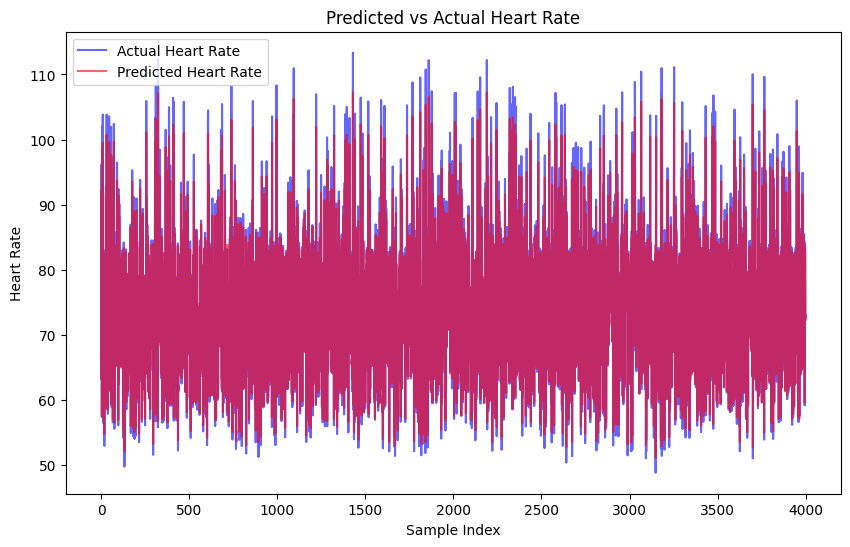

In [16]:
# **Section 9: Visualization - Line Plot (Predicted vs Actual Heart Rate)**
# Line Plot: Predicted vs Actual Heart Rate
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Heart Rate', color='b', alpha=0.6)
plt.plot(y_pred_rescaled, label='Predicted Heart Rate', color='r', alpha=0.6)
plt.title('Predicted vs Actual Heart Rate')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

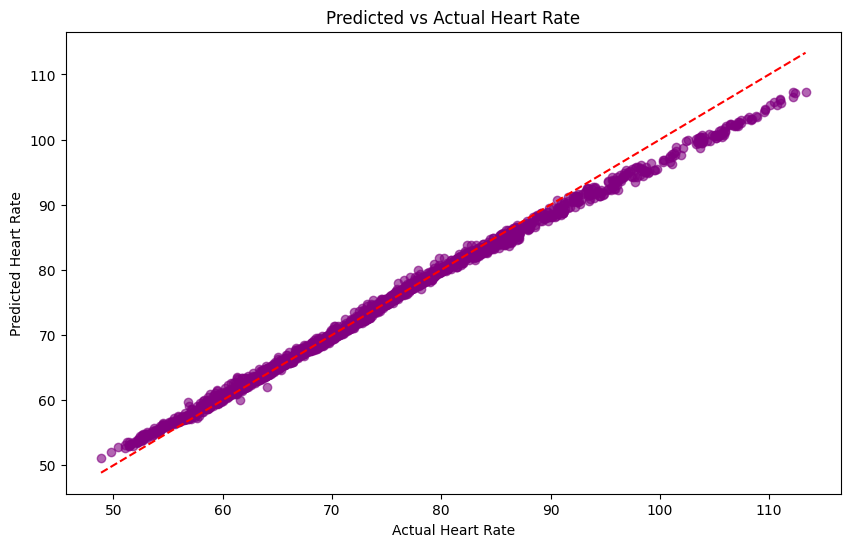

In [17]:
# **Section 10: Visualization - Scatter Plot (Predicted vs Actual Heart Rate)**
# Scatter Plot: Predicted vs Actual Heart Rate
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6, color='purple')
plt.title('Predicted vs Actual Heart Rate')
plt.xlabel('Actual Heart Rate')
plt.ylabel('Predicted Heart Rate')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='r', linestyle='--')  # Diagonal line
plt.show()

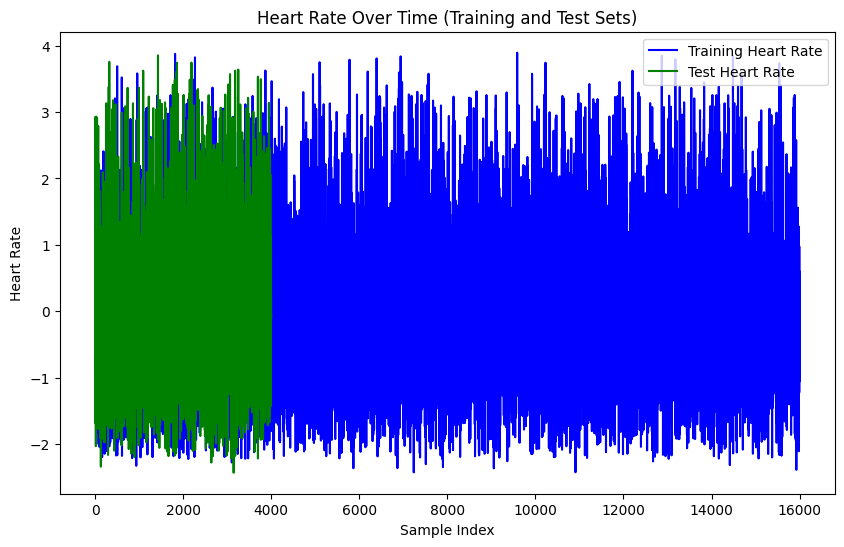

In [18]:
# Line plot for actual heart rate
plt.figure(figsize=(10, 6))
plt.plot(y_train.flatten(), label='Training Heart Rate', color='blue')
plt.plot(y_test.flatten(), label='Test Heart Rate', color='green')
plt.title('Heart Rate Over Time (Training and Test Sets)')
plt.xlabel('Sample Index')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()


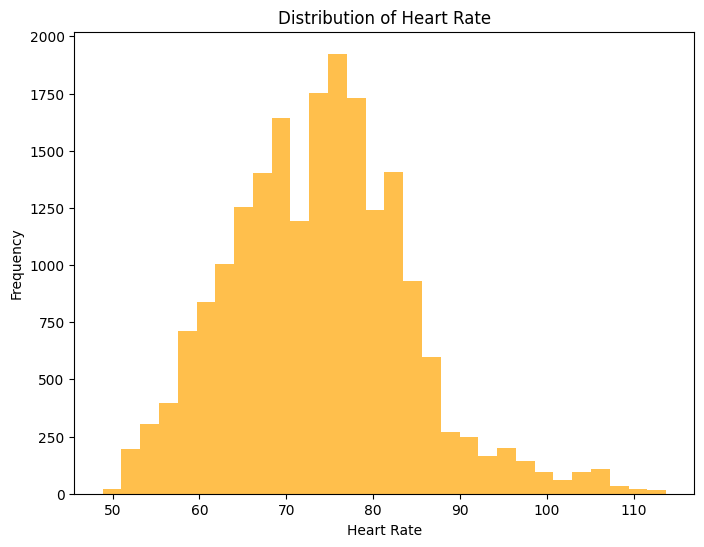

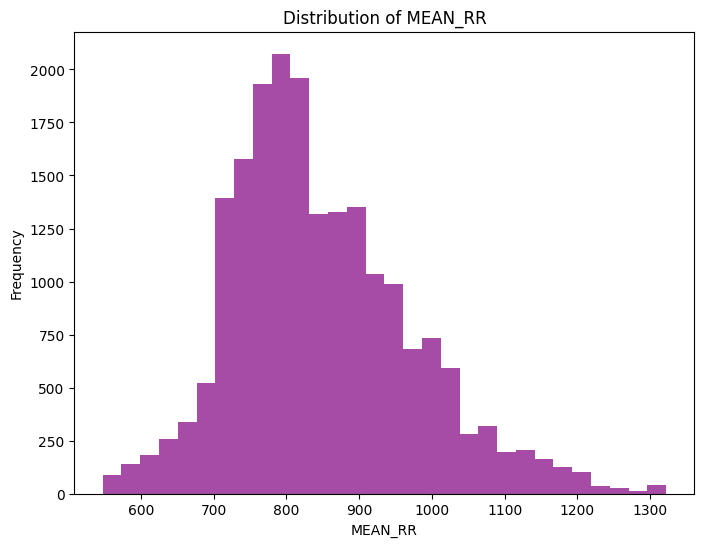

In [19]:
# Histogram for Heart Rate
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Heart Rate')
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.show()

# Histogram for a specific feature (e.g., MEAN_RR)
plt.figure(figsize=(8, 6))
plt.hist(merged_data['MEAN_RR'], bins=30, color='purple', alpha=0.7)
plt.title('Distribution of MEAN_RR')
plt.xlabel('MEAN_RR')
plt.ylabel('Frequency')
plt.show()


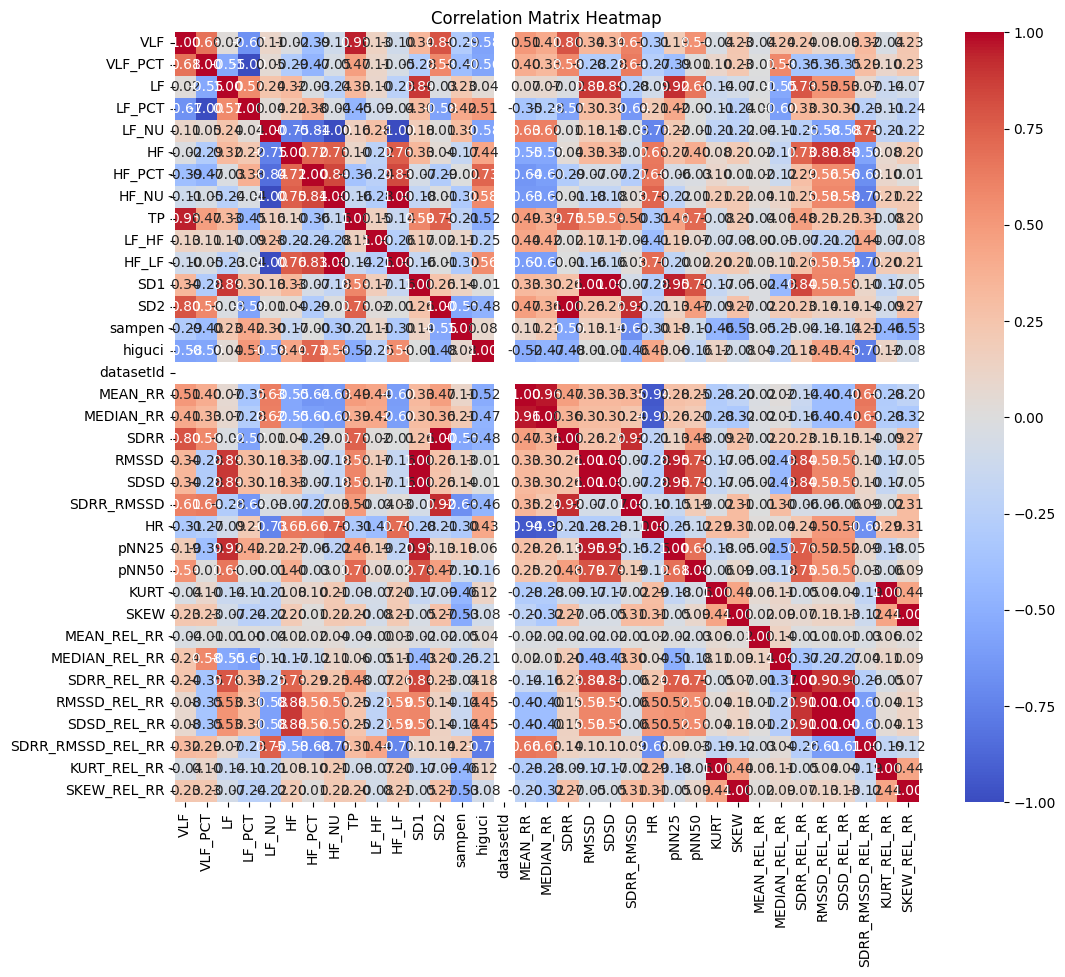

In [20]:
import seaborn as sns

# Compute correlation matrix
corr_matrix = merged_data.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


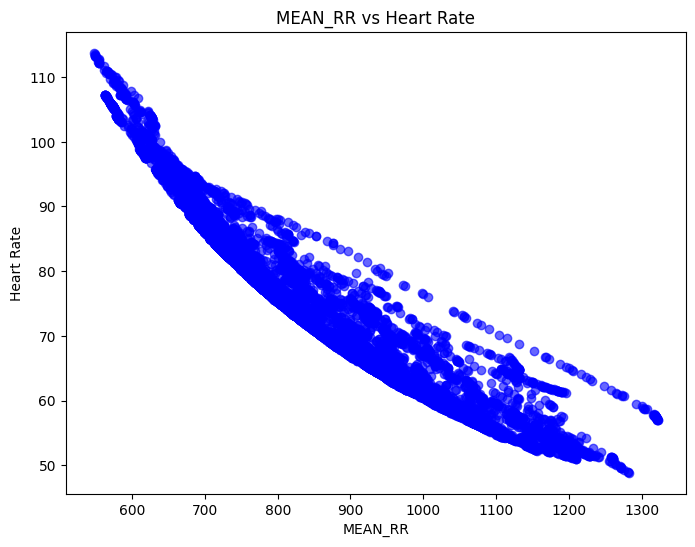

In [23]:
# Scatter Plot: Feature vs Heart Rate
plt.figure(figsize=(8, 6))
plt.scatter(merged_data['MEAN_RR'], merged_data['HR'], alpha=0.6, color='blue')
plt.title('MEAN_RR vs Heart Rate')
plt.xlabel('MEAN_RR')
plt.ylabel('Heart Rate')
plt.show()
